# Langgraph with graphQAchain

In [2]:
import os 
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from langchain.chains import GraphQAChain
from langchain_openai import AzureChatOpenAI
import dotenv
from pathlib import Path 
import json 
import pandas as pd 

In [3]:
dotenv.load_dotenv()
from openai import AzureOpenAI
llm=AzureOpenAI(
        api_key=os.getenv('AZURE_OPENAI_API_KEY_4'),
        azure_endpoint=os.getenv('AZURE_OpenAI_ENDPOINT_4'),
        api_version=os.getenv('AZURE_OpenAI_API_VERSION_4'),
        # model_name=os.getenv('AZURE_OpenAI_model_name')
)


In [4]:
with open(Path('Nodes_and_edges.json'),'r') as f:
    data=json.load(f)


In [5]:
df=pd.DataFrame(data)
df.shape

(2137, 3)

In [6]:
# create a graph 
graph=NetworkxEntityGraph()

# add nodes to the graph
for node in data:
    try:
        graph.add_node(node['node_1'])
        graph.add_node(node['node_2'])
    except Exception as e:
        print(f'node not found {e}')

# add edges to the graph 
for edge in data:
    try:
        graph._graph.add_edge(
            edge['node_1'],
            edge['node_2'],
            relation=edge['edge']
        ) 
    except Exception as e:
        print(e)

In [7]:
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OpenAI_API_VERSION"),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL'),
    model_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL'),
    api_key=os.getenv('GRAPHRAG_API_KEY'),
   )
# create a graph QA chain 
rag_chain=GraphQAChain.from_llm(
    llm=llm,
    graph=graph,
    verbose=True
)


In [8]:
# lang graph system over the graph rag system 
from typing import Dict, TypedDict, Optional
from langgraph.graph import StateGraph, END 

class GraphState(TypedDict):
    question: Optional[str]=None 
    classificaiton: Optional[str]=None
    response: Optional[str]=None 
    greeting: Optional[str]=None 
    revised_question: Optional[str]=None 

def classify(question):
    return llm(f'classify intent of given input as greeting or not_greeting. Output just the class "greeting" or "not_greeting".Input :{question}')

def classify_input_node(state):
    question=state.get('question','').strip()
    classification=classify(question)
    return {'Classification':classification}

def handle_greeting_node(state):
    return {'greeting':'Hello There'}

def handle_RAG(state):
    question=state.get('revised_question','').strip()
    prompt=question
    search_result=rag_chain.run(prompt)
    question=llm(f'Rephrase this questions: {question}')
    print('question',question)
    print('response',search_result)
    return {'response':search_result,'revised_question':question}

def bye(state):
    return {'greeting':"the graph has finished"}


In [ ]:

workflow=StateGraph(GraphState)
workflow.add_node('classify_input',classify_input_node)
workflow.add_node('handle_greeting',handle_greeting_node)
workflow.add_node('handle_rag',handle_RAG)
workflow.add_node('bye',bye)

workflow.set_entry_point('classify_input')
workflow.add_edge('handle_greeting',END)
workflow.add_edge('bye',END)

def decide_next_node(state):
    return 'handle_greeting' if state.get('classification')=='greeting' else 'handle_rag'

def check_RAG_length(state):
    response=state.get('response')
    question=state.get('question')
    meaning=llm(f'Response:{response}, Does the response means: "I cannot answer the question?" Output Yes or No')
    print('is the output I dont know??',meaning)
    return 'bye' if 'no' in str(meaning).lower() else 'handle_rag'

workflow.add_conditional_edges(
    'classify_input',
    decide_next_node,
    {
        'handle_greeting':'handle_greeting',
        'handle_rag':'handle_rag'
    }
)
workflow.add_conditional_edges(
    'handle_rag',
    check_RAG_length,
    {
        'bye':'bye',
        'handle_rag':'handle_rag'
    }
)

app=workflow.compile()


In [28]:
#graph.get_triples()

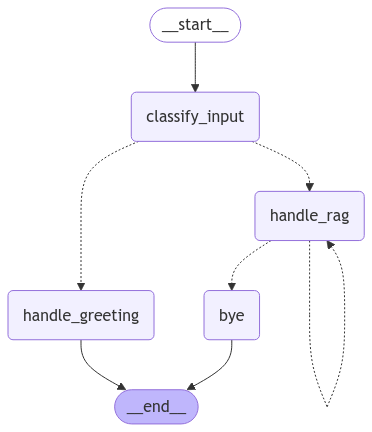

In [11]:
# visualize the graph 
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API, 
        )
    )
)

In [19]:
prompt='how is bill gates related to sam altman?'
app.invoke({'question':prompt,'revised_question':prompt})



> Entering new GraphQAChain chain...
Entities Extracted:
Bill Gates, Sam Altman
Full Context:
Bill Gates Bill Gates is a former CEO of Microsoft, instrumental in its founding and growth. Microsoft
Bill Gates Bill Gates co-founded the Bill & Melinda Gates Foundation, the world's largest private charity. Bill & Melinda Gates Foundation
Bill Gates Bill Gates has been involved in various efforts and investments concerning climate change and energy. climate change and energy
Bill Gates Bill Gates has expressed positions and involvement regarding the regulation and impact of cryptocurrencies. cryptocurrencies
Bill Gates Bill Gates has made significant personal donations to various causes. personal donations
Bill Gates Bill Gates has participated in charity sports events to raise funds and awareness for different causes. charity sports events
Bill Gates Bill Gates had a controversial relationship with Jeffrey Epstein. Jeffrey Epstein
Bill Gates Bill Gates was involved in antitrust litigatio

{'question': 'how is bill gates related to sam altman?',
 'response': 'Bill Gates and Sam Altman are related through their involvement in Microsoft. Sam Altman joined Microsoft to lead a new advanced AI research team.',
 'greeting': 'the graph has finished',
 'revised_question': AIMessage(content='What is the connection between Bill Gates and Sam Altman?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 22, 'total_tokens': 34, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'sto

In [13]:
prompt='how is stanford university related to people in this network?'
app.invoke({'question':prompt,'revised_question':prompt})



> Entering new GraphQAChain chain...
Entities Extracted:
Stanford University
Full Context:
Stanford University Altman attended Stanford University but dropped out after two years. Altman
Stanford University Stanford University offered a Computer science PhD program in which Page enrolled. Computer science PhD program

> Finished chain.
question content='What is the connection between Stanford University and individuals in this network?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 24, 'total_tokens': 37, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'sa

{'question': 'how is stanford university related to people in this network?',
 'response': 'Stanford University is related to people in this network as an educational institution where they either enrolled in or dropped out from a program.',
 'greeting': 'the graph has finished',
 'revised_question': AIMessage(content='What is the connection between Stanford University and individuals in this network?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 24, 'total_tokens': 37, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': Fals

In [14]:
prompt='give me a list of people connected to stanford university, atleast more than 7?'
app.invoke({'question':prompt,'revised_question':prompt})



> Entering new GraphQAChain chain...
Entities Extracted:
NONE
Full Context:


> Finished chain.
question content='Can you provide a list of at least seven individuals associated with Stanford University?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 30, 'total_tokens': 45, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, '

{'question': 'give me a list of people connected to stanford university, atleast more than 7?',
 'response': '1. Herbert Hoover - Former President of the United States and alumnus\n2. Elon Musk - CEO of SpaceX and Tesla, studied there briefly\n3. Larry Page - Co-founder of Google, alumnus\n4. Sergey Brin - Co-founder of Google, alumnus\n5. Condoleezza Rice - Former U.S. Secretary of State and professor\n6. John Steinbeck - Nobel laureate in Literature, former student\n7. William Hewlett - Co-founder of Hewlett-Packard, alumnus\n8. David Packard - Co-founder of Hewlett-Packard, alumnus',
 'greeting': 'the graph has finished',
 'revised_question': AIMessage(content='Can you provide a list of at least seven individuals associated with Stanford University?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 30, 'total_tokens': 45, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-202

In [15]:
prompt='how is sundar pichai related to people in this network?'
app.invoke({'question':prompt,'revised_question':prompt})



> Entering new GraphQAChain chain...
Entities Extracted:
Sundar Pichai
Full Context:
Sundar Pichai Sundar Pichai is the CEO of Google. Google
Sundar Pichai Sundar Pichai has a dedicated Wikipedia page detailing his life and career. Wikipedia
Sundar Pichai Sundar Pichai also became the CEO of Alphabet Inc. in 2019. Alphabet Inc.
Sundar Pichai Sundar Pichai graduated with a BTech from the Indian Institute of Technology Kharagpur. Indian Institute of Technology Kharagpur
Sundar Pichai Sundar Pichai holds an MS in materials science and engineering from Stanford University. Stanford University
Sundar Pichai Sundar Pichai obtained an MBA from the University of Pennsylvania. University of Pennsylvania
Sundar Pichai Sundar Pichai received the Padma Bhushan, India's third-highest civilian award, in 2022. Padma Bhushan
Sundar Pichai Sundar Pichai served as a board member of Magic Leap from 2014 to 2018. Magic Leap
Sundar Pichai Sundar Pichai is married to Anjali Pichai. Anjali Pichai
Sundar Pi

{'question': 'how is sundar pichai related to people in this network?',
 'response': 'Sundar Pichai is related to several people and entities in multiple ways:\n\n1. **Professional Relationships**:\n   - He is the CEO of both Google and Alphabet Inc., overseeing their operations.\n   - He has worked with major companies like McKinsey & Company and Applied Materials in various capacities.\n\n2. **Educational and Personal Connections**:\n   - Graduated from the Indian Institute of Technology Kharagpur, Stanford University, and the University of Pennsylvania’s Wharton School.\n   - He is married to Anjali Pichai.\n\n3. **Organizational Affiliations**:\n   - Served as a board member at Magic Leap.\n   - Appointed to the Alphabet Board of Directors.\n\n4. **Public and Cultural Engagements**:\n   - Spoke at significant conferences, represented Google in a Congressional hearing, and has been active in discussions impacting global internet governance.\n\nThese relationships and affiliations hi

In [27]:
prompt='give me infromation on github'
app.invoke({'question':prompt,'revised_question':prompt})



> Entering new GraphQAChain chain...
Entities Extracted:
NONE
Full Context:


> Finished chain.
question content='Can you provide me with information about GitHub?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 19, 'total_tokens': 28, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'

{'question': 'give me infromation on github',
 'response': 'GitHub is a web-based platform used for version control and collaborative software development. It allows multiple developers to work together on projects and provides tools for managing code changes, reviewing code, and tracking issues. It also features social networking elements, such as feeds, followers, and activity tracking, making it popular among the open-source community. GitHub supports Git, a distributed version control system, and offers both public and private repositories.',
 'greeting': 'the graph has finished',
 'revised_question': AIMessage(content='Can you provide me with information about GitHub?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 19, 'total_tokens': 28, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'prompt_filter_results': [{'promp

# visualize the network graph

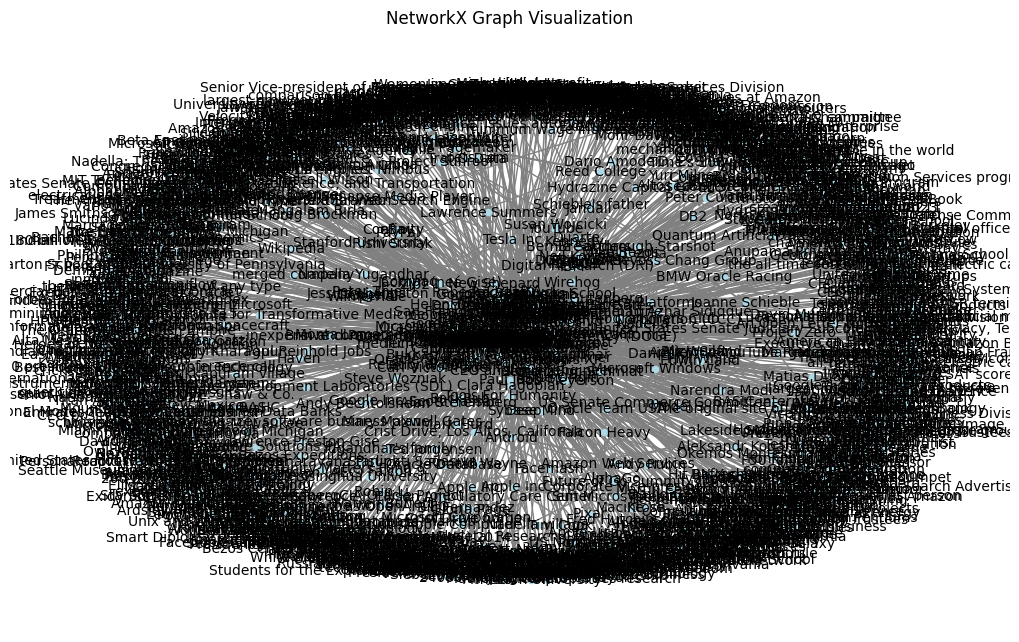

In [26]:
import networkx as nx 
import matplotlib.pyplot as plt 
from langchain_community.graphs.networkx_graph import parse_triples,NetworkxEntityGraph

nx_graph = graph._graph # Access the underlying NetworkX graph

# Define layout
pos = nx.spring_layout(nx_graph)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(nx_graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=20, font_size=10)
plt.title("NetworkX Graph Visualization")
plt.show()